In [400]:
import itertools

import pandas as pd 
from scipy.stats import mannwhitneyu,chi2_contingency,pearsonr,spearmanr,shapiro,ttest_ind,normaltest
import seaborn as sns
import matplotlib.pyplot as plt
import random
from itertools import combinations

In [401]:
# Начнем с загрузки данных и сохранения в соответствующие переменных
database=pd.read_csv('market_file.csv',delimiter=',')
data_money=pd.read_csv('money.csv',delimiter=';',decimal=',')
data_forecast=pd.read_csv('forecast_chan.csv',delimiter=';',decimal=',',encoding='cp1251')
data_market_money=pd.read_csv('market_money.csv',delimiter=',')
data_market_time=pd.read_csv('market_time.csv',delimiter=',')
data_list=[database,data_money,data_forecast,data_market_money,data_market_time]

In [402]:
# измените названия столбцов, чтобы они соответствовали формату pep8
for data in data_list:
    column_names=list(data.columns)
    corrected_column_names=list(map(lambda x:x.lower().replace(' ','_'),column_names))
    data.columns=corrected_column_names
data_market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [403]:
# теперь выведем основную информацию о числовых столбцах
database[[i for i in database.columns if i != 'id']].describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [404]:
def explore_categories_text(df,column):
    print('-'*50)
    print(f'Рассматриваемая колонна: {column}')
    print(f'Колличество пропусков: {df[column].isna().sum()}')
    print(f'Тип данных в колонне: {df[column].dtype}')
    if df[column].dtype == object:
        print(f'Значения в колонке: {df[column].value_counts()}')
        print(f'Уникальные значения: {df[column].unique()}')
    

In [405]:
# Теперь давайте изучим наши данные с помощью различных графиков
# Начнем с базы данных
print(database.columns)
all_data_types=set(database.dtypes)
print(all_data_types)
for column_name in database:
    explore_categories_text(database,column_name)
# Что мы исследовали: в столбце Тип услуги произошла ошибка ввода
# Популярная категория содержит 6 различных категорий, они могут быть объединены в "товары для себя" и "товары для дома

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
{dtype('int64'), dtype('O'), dtype('float64')}
--------------------------------------------------
Рассматриваемая колонна: id
Колличество пропусков: 0
Тип данных в колонне: int64
--------------------------------------------------
Рассматриваемая колонна: покупательская_активность
Колличество пропусков: 0
Тип данных в колонне: object
Значения в колонке: покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64
Уникальные значения: ['Снизилась' 'Прежний уровень']
--------------------------------------------------
Рассматриваемая колонна: тип_сервиса
Колличество пропусков: 0
Тип данных в колонне: 

In [406]:
# Исправьте ошибку типа в 'Тип сервиса'
# print(database['Тип сервиса'].unique()) -> 3 разных значения

database['тип_сервиса']=database['тип_сервиса'].apply(lambda x:'стандарт' if x.startswith('стан') else x)
print(database['тип_сервиса'].unique())

['премиум' 'стандарт']


In [407]:
colors = ['cadetblue', 'violet', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'maroon', 'coral']


def draw_pie_plots_bar_plots(df, column, ax):
    global colors
    value_counts = df[column].value_counts()
    index = value_counts.index
    explode = [i * 0.1 for i in range(len(index))]
    ax.pie(value_counts, labels=index, shadow=True, autopct='%1.1f%%', colors=colors, explode=explode, startangle=90,
           textprops={'fontsize': 15, 'color': 'black', 'weight': 'bold'})
    ax.axis('equal')
    ax.set_title(column, fontsize=20, y=1.1)


def draw_bar_plot(df, column, ax, text):
    values = df[column].value_counts()
    color_map = {i: colors[index_] for index_, i in enumerate(values.index)}
    bars = ax.bar(values.index, values.values, color=[color_map[c] for c in values.index])
    if text is True:
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                    str(int(bar.get_height())), fontsize=20)
    else:
        ax.set_xticklabels([])
    ax.set_title(column, fontsize=20, y=1.1)
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[label]) for label in values.index]
    legend_numbers = [f'{label}: {count}' for label, count in zip(values.index, values.values)]
    ax.legend(legend_handles, legend_numbers, fontsize=15, loc='upper left')


def draw_box_plot(df, column, ax):
    sns.boxplot(data=df, x=column, ax=ax)
    ax.set_title(label=column, fontsize=40)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)


def draw_histplot(df, column, ax):
    sns.histplot(data=df, x=column, ax=ax, kde=True)
    ax.set_title(label=column, fontsize=40)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)


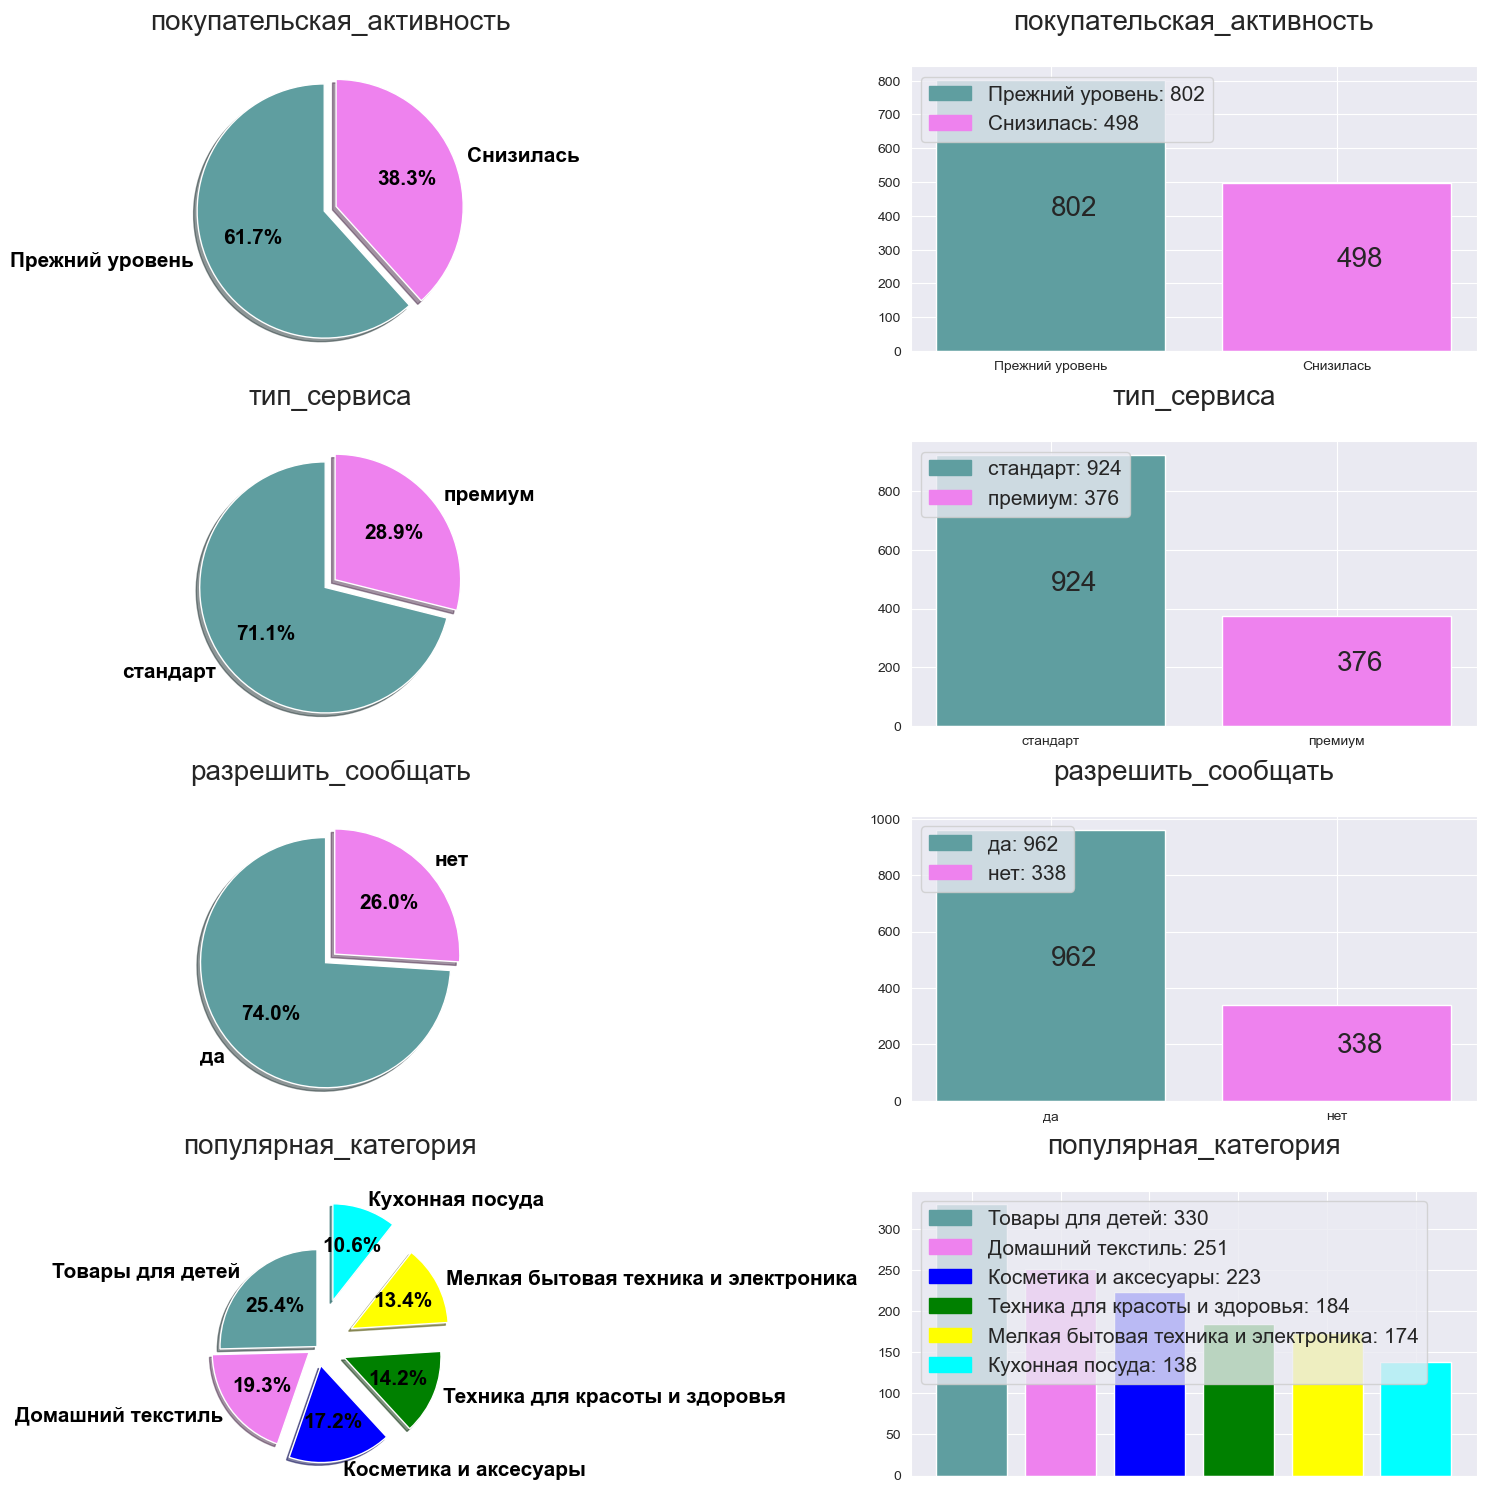

In [408]:
# Теперь нарисуем графики для каждого столбца.
# Начнем с категориальных круговых диаграмм и столбчатых диаграмм

categorical_columns=database.select_dtypes(include=['object'])
num=categorical_columns.shape[1]
fig,axes=plt.subplots(num,2,figsize=(15,15))
plt.title('Pie Plots for database')
show_text=True
for index,categ in enumerate(categorical_columns):
    draw_pie_plots_bar_plots(database,categ,axes[index][0])
    if index==num-1:
        show_text=False
    draw_bar_plot(database,categ,axes[index][1],show_text)
plt.tight_layout()
# plt.savefig('da.jpg')
plt.show()
# в колонке покупательская активность (целевая) значений прежний уровень больше
# тип сервиса стандарт встречается более чем в два раза чаще 
# большинство пользователей разрешили сообщать 
# самая популярная категория - товары для детей

In [409]:
# Интересно проверить, какие категориальные переменные могут влиять на покупательскую активность
p_value_list=[]
for feature in categorical_columns:
    if feature != 'покупательская_активность':
        table=pd.crosstab(database[feature],database['покупательская_активность'])
        p_value_list.append([feature,chi2_contingency(table)[1]])
print(p_value_list)
# Согласно списку значений, разрешение сообщать никак не влияет на покупательскую активность (нулевая гипотеза принята)
# Замечено среднее по силе влияние на покупательскую активность колонки тип сервиса
# Самая сильная связь - это покупательская активность и попелярная категория. 
# Эти данные могут пригодиться при сегментации данных.

[['тип_сервиса', 0.0013552678292615076], ['разрешить_сообщать', 0.7967675314637721], ['популярная_категория', 1.6773130972483084e-12]]


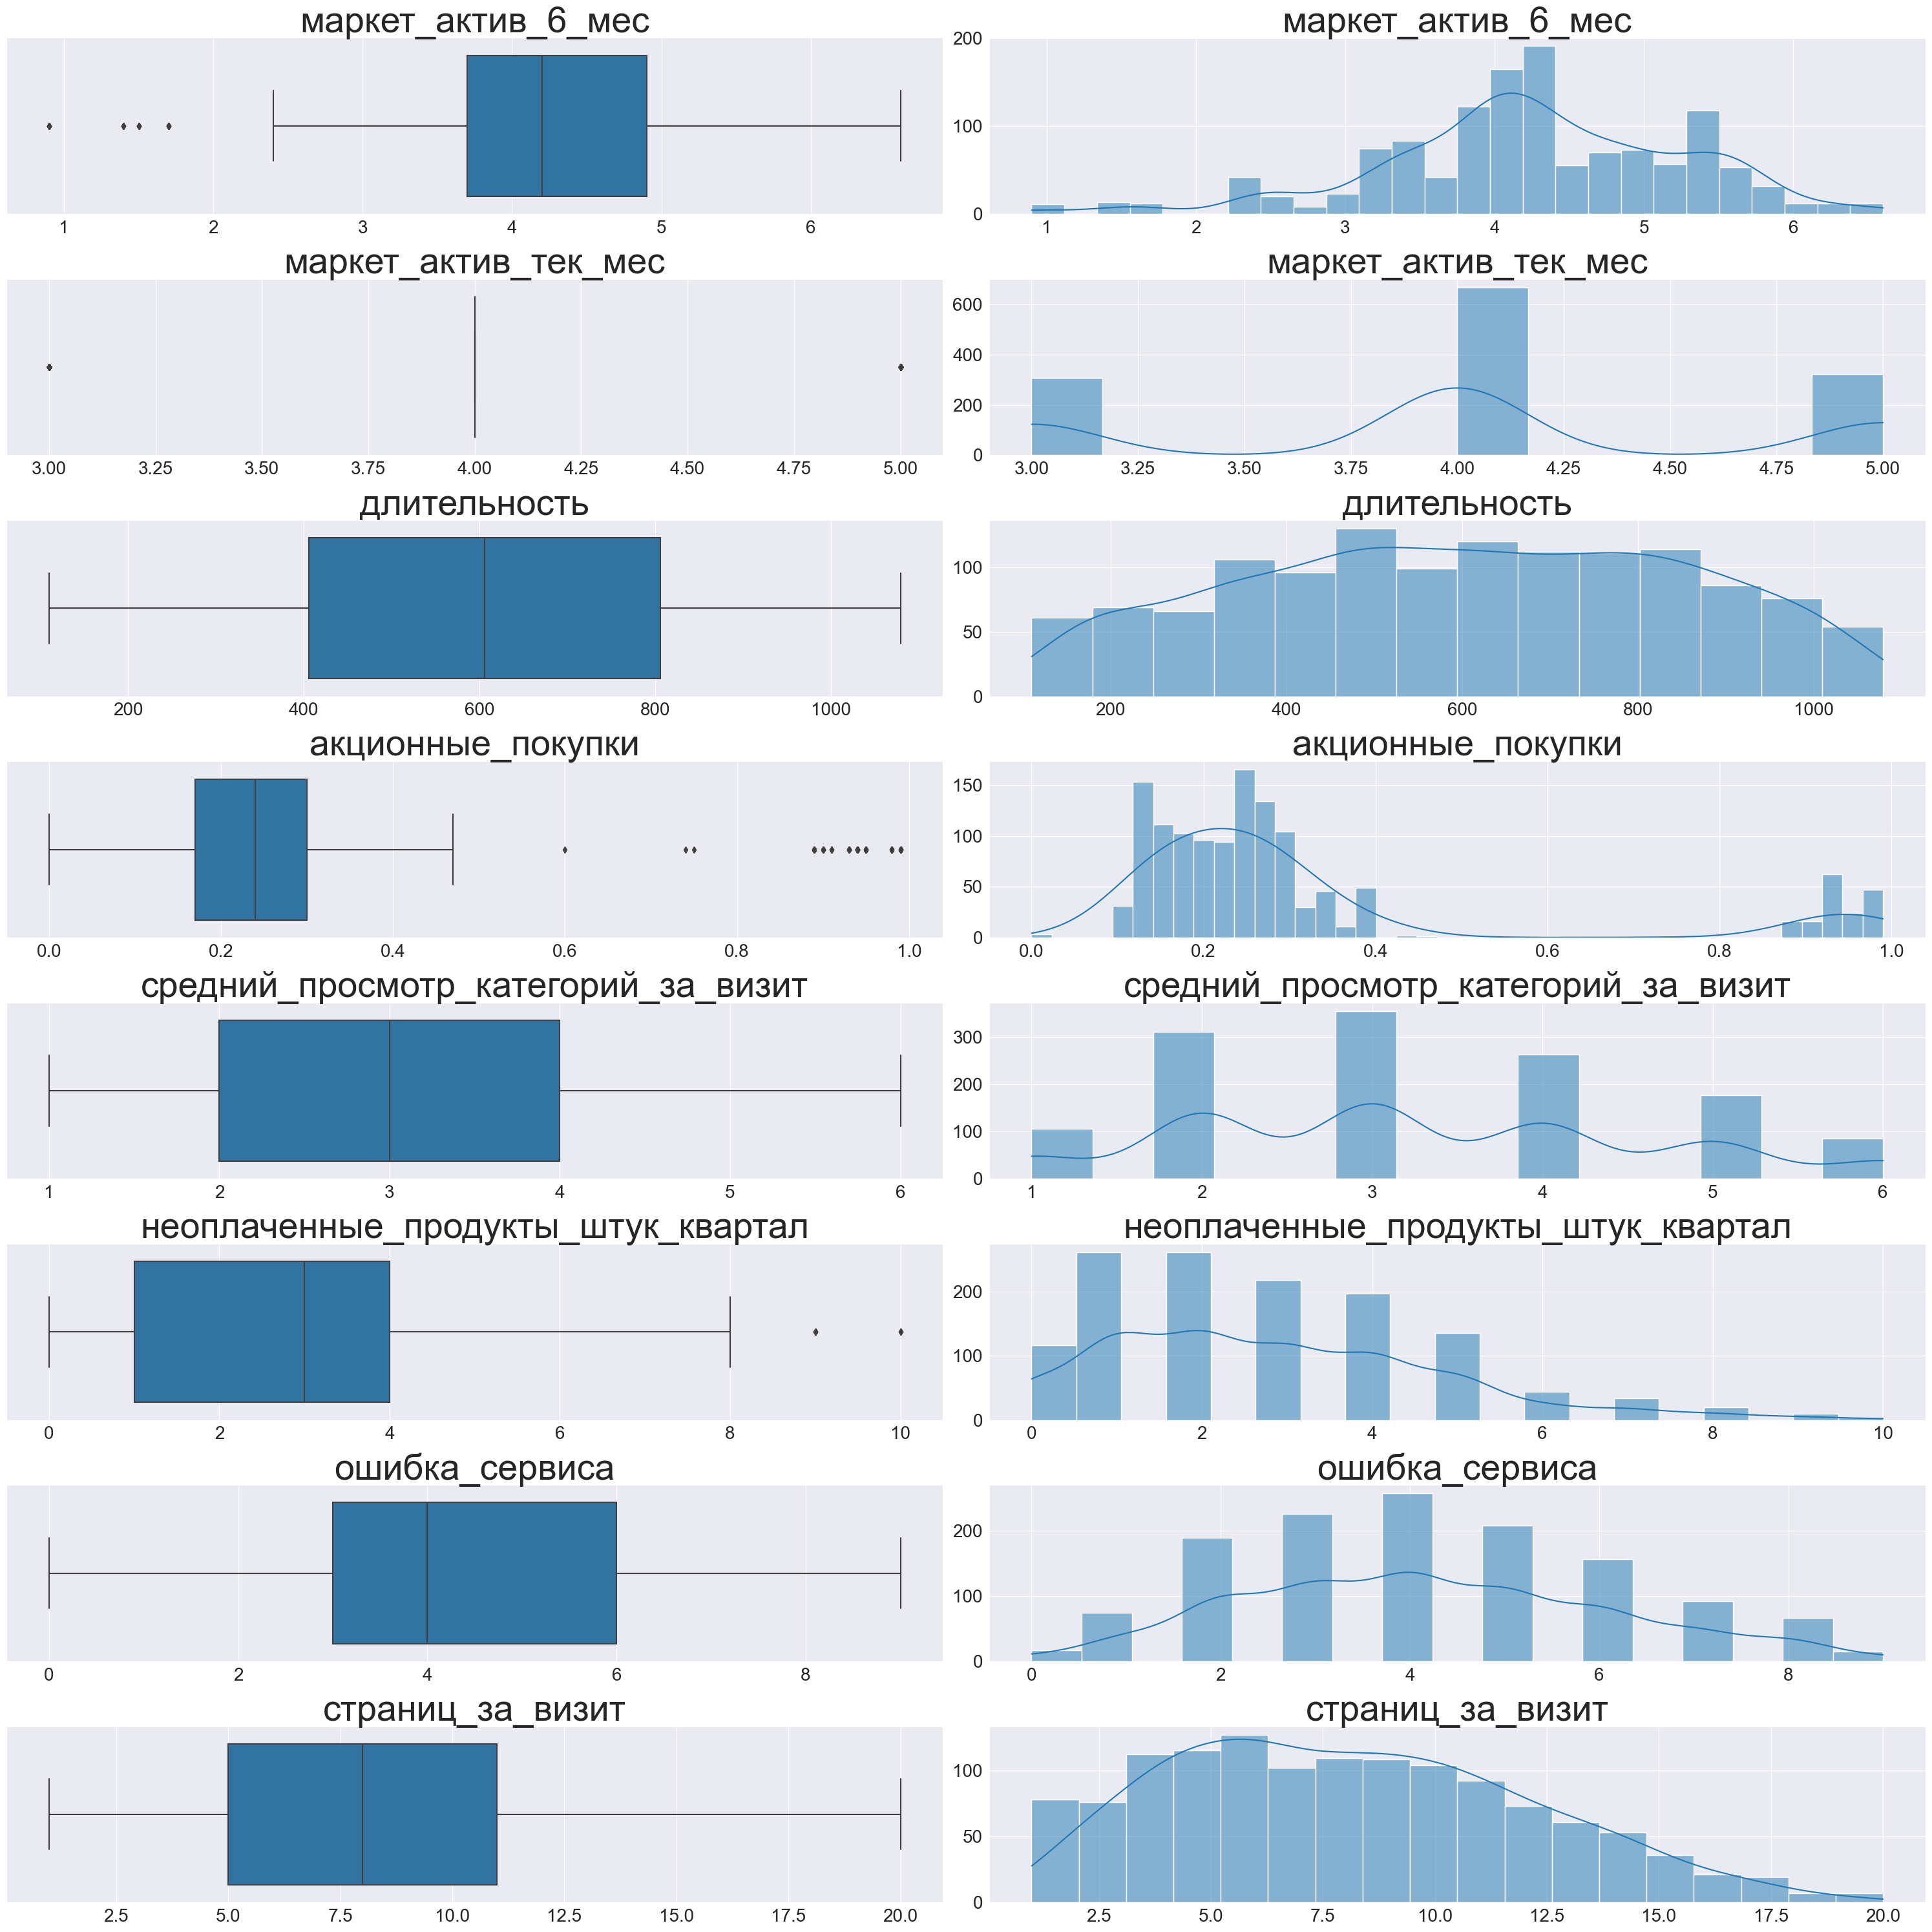

Данные в колонке маркет_актив_6_мес распределены ненормально
Данные в колонке маркет_актив_тек_мес распределены ненормально
Данные в колонке длительность распределены ненормально
Данные в колонке акционные_покупки распределены ненормально
Данные в колонке средний_просмотр_категорий_за_визит распределены ненормально
Данные в колонке неоплаченные_продукты_штук_квартал распределены ненормально
Данные в колонке ошибка_сервиса распределены ненормально
Данные в колонке страниц_за_визит распределены ненормально


In [410]:
# Теперь мы исследуем числовые данные
numerical_columns=database.drop('id',axis=1).select_dtypes(include = [int,float])
# print(categorical_columns.shape[1]+numerical_columns.shape[1]==database.columns.shape[0]) -> True все колонки рассмотрены 
fig,axes=plt.subplots(numerical_columns.shape[1],2,figsize=(30,30))
normality_test=dict()
for index,column_name in enumerate(numerical_columns):
    normality_test[column_name]=shapiro(database[column_name])[1]>0.05
    draw_box_plot(database,column_name,axes[index][0])
    draw_histplot(database,column_name,axes[index][1])
plt.tight_layout()
# plt.savefig('da_1.jpg')
plt.show()
for columns in normality_test.keys():
    print(f'Данные в колонке {columns} распределены нормально' if normality_test[columns] is True else f'Данные в колонке {columns} распределены ненормально')
# Выводы
# маленькие выбросы в маркет_актив_6_мес, можно не удалять 
# в маркет_актив_тек_мес по графику ящик с усами похоже есть выбросы, но там присутствуют только 3 значения, поэтому выбросы не считаются
# График длительность выглядит хорошо, похоже на нормальное распространение данных. Проверим потом с шапиро
# в колонке акционные покупки много выбросов, некоторые очень грубые - стоит удалить 
# средний просмотр категорий за визит - медиана 3, мин 1 макс 6
# немного негрубых выбросов в неопаченных покупках 
# в ошибке сервисах и страницах за визит выбросов нет, скорее всего распределение нормальное 
# во всех колонках данные распределены ненормально

In [411]:
# Займемся выбросами, используем метод межквартильного размаха, большие и маленькие значения заменим на медианну группы с одиннаковой покупательской активностью. (в базе данных более 1000 значений, это будет подходящая замена)
# все данные распределены ненормально -> для определения выбросов можно использовать интерквартильный размах
def insert_median_values(df, row, column_name):
    median_from_df = df[df['покупательская_активность'] == row['покупательская_активность']][column_name].median()
    return median_from_df

def define_big_value(df, column):
    inter_quantile = df[column].quantile(0.75) - df[column].quantile(0.25)
    biggest_threshold = df[column].quantile(0.75) + inter_quantile
    smallest_threshold = df[column].quantile(0.25) - inter_quantile
    return smallest_threshold, biggest_threshold

problem_columns = ['маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал']

for column in problem_columns:
    small_val, big_val = define_big_value(database, column)
    print(f'В колонке {column} обнаружены {len(database[database[column] < small_val])} грубых в меньшую сторону и {len(database[database[column] > big_val])} выбросов в большую сторону')
    database[column] = database.apply(lambda x: insert_median_values(database, x, column) if (x[column] < small_val or x[column] > big_val) else x[column], axis=1)


В колонке маркет_актив_6_мес обнаружены 78 грубых в меньшую сторону и 24 выбросов в большую сторону
В колонке акционные_покупки обнаружены 3 грубых в меньшую сторону и 171 выбросов в большую сторону
В колонке неоплаченные_продукты_штук_квартал обнаружены 0 грубых в меньшую сторону и 34 выбросов в большую сторону


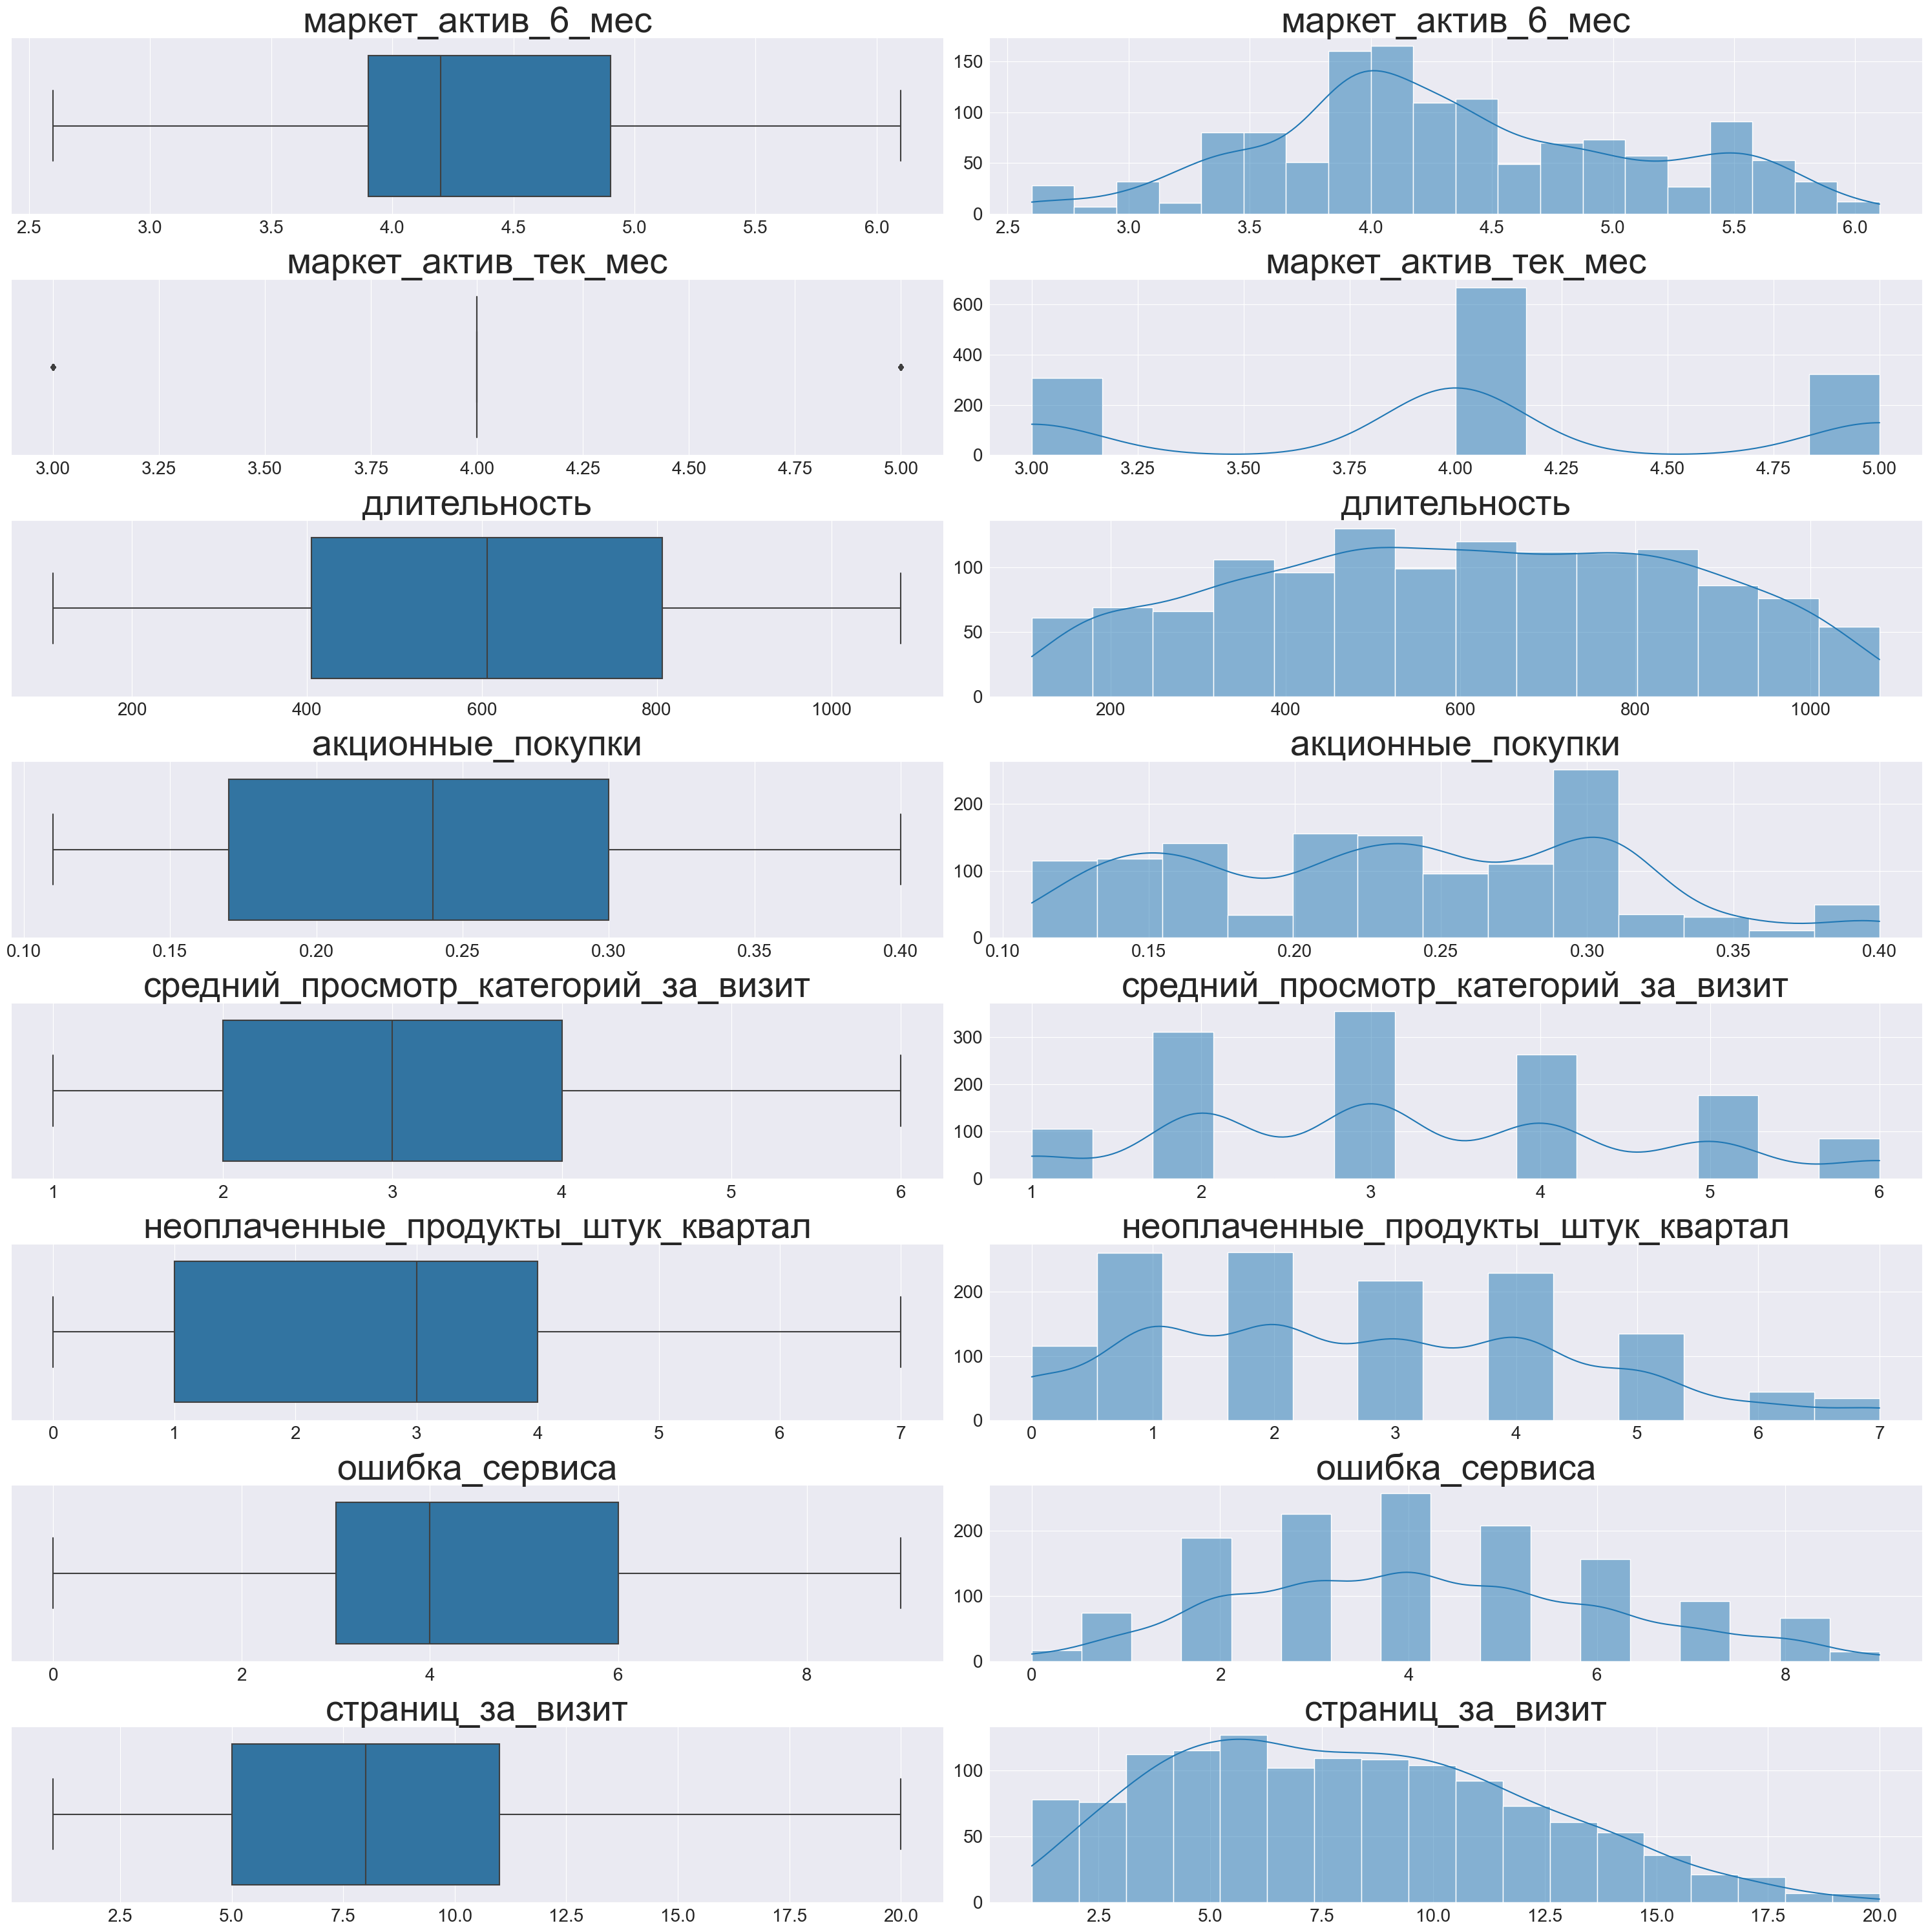

In [412]:
# Выведем графики еще раз
numerical_columns=database.drop('id',axis=1).select_dtypes(include = [int,float])
fig,axes=plt.subplots(numerical_columns.shape[1],2,figsize=(30,30))
for index,column_name in enumerate(numerical_columns):
    draw_box_plot(database,column_name,axes[index][0])
    draw_histplot(database,column_name,axes[index][1])
plt.tight_layout()
# plt.savefig('to_compare.jpg')
plt.show()
# как видно по графикам, выбросы были заменены. На боксплотах отсутсвуют точки. 

In [413]:
print(database.duplicated().sum())
print(database.isna().sum())
# предобработка данных завершена. Выбросы заменены медианой, пропуски удалены (всего 2 штуки). Дубликатов строк не обнаружено.

0
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64


id прибыль True
(4, 2)
0.20248748362064362
True
count    1300.000000
mean        3.996343
std         0.997728
min         0.980000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.020000
Name: прибыль, dtype: float64


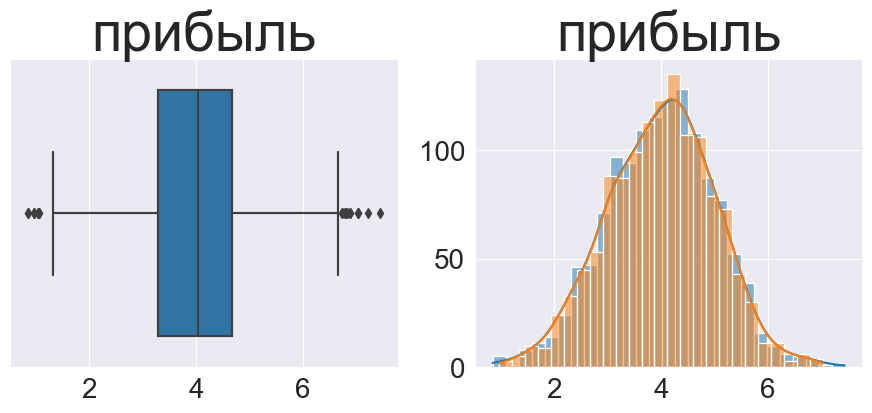

In [414]:
def check_values(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    return mean - 3 * std, mean + 3 * std


# приступаем к другой таблице: money.csv
for columns in data_money:
    print(columns, end=' ')
# таблица содержит только 2 колонки id и прибыль 
# начертим графики для прибыли 
figure, ax = plt.subplots(1, 2, figsize=(11, 4))
draw_box_plot(data_money, column='прибыль', ax=ax[0])
draw_histplot(data_money, column='прибыль', ax=ax[1])
# Похоже на нормальное распределение данных, проверим шапиро с уровнем принятия решения 0.05
print(shapiro(data_money['прибыль'])[1] > 0.05)
# Данные распределены нормально, проверим на выбросы с помощью метода среднее +- 3 стандартных отклонения 
small, big = check_values(data_money, 'прибыль')
print(data_money[(data_money['прибыль'] < small) | (data_money['прибыль'] > big)].shape)
# всего 4 выбросов, заменим на среднее значение 
average_val = data_money.прибыль.mean()
data_money['прибыль'] = data_money['прибыль'].apply(lambda x: average_val if (x > big or x < small) else x)
draw_box_plot(data_money, column='прибыль', ax=ax[0])
draw_histplot(data_money, column='прибыль', ax=ax[1])
# Синий график - до, желтый после. На боксплоте значения усов сместились ближе к медиане, все маленькие и большие значения были заменены средними.
print(shapiro(data_money['прибыль'])[1])
print(shapiro(data_money['прибыль'])[1] > 0.05)
# Данные все так же распределены нормально
print(data_money['прибыль'].describe())

вероятность id 6.375978077601134e-40


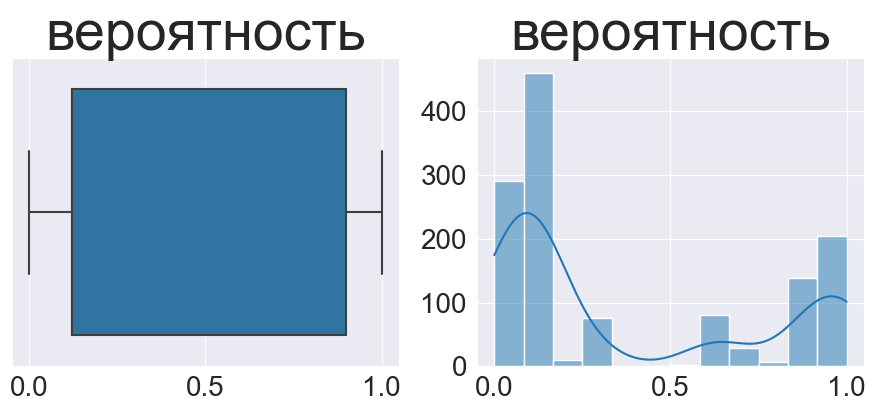

In [415]:
# Сейчас исследуем таблицу forecast_chan
for columns in data_forecast:
    print(columns, end=' ')
# таблица сожержит предсказания (вероятность снижения покупательской активности) и id пользователей
# здесь не надо удалять выбросы, просто выведем графики 
figure, ax = plt.subplots(1, 2, figsize=(11, 4))
draw_box_plot(data_forecast, column='вероятность', ax=ax[0])
draw_histplot(data_forecast, column='вероятность', ax=ax[1])
print(shapiro(data_forecast['вероятность'])[1])

id
215348     3293.1
215359     4735.0
215357     5986.3
215564    10437.6
215716    10575.9
Name: выручка, dtype: float64


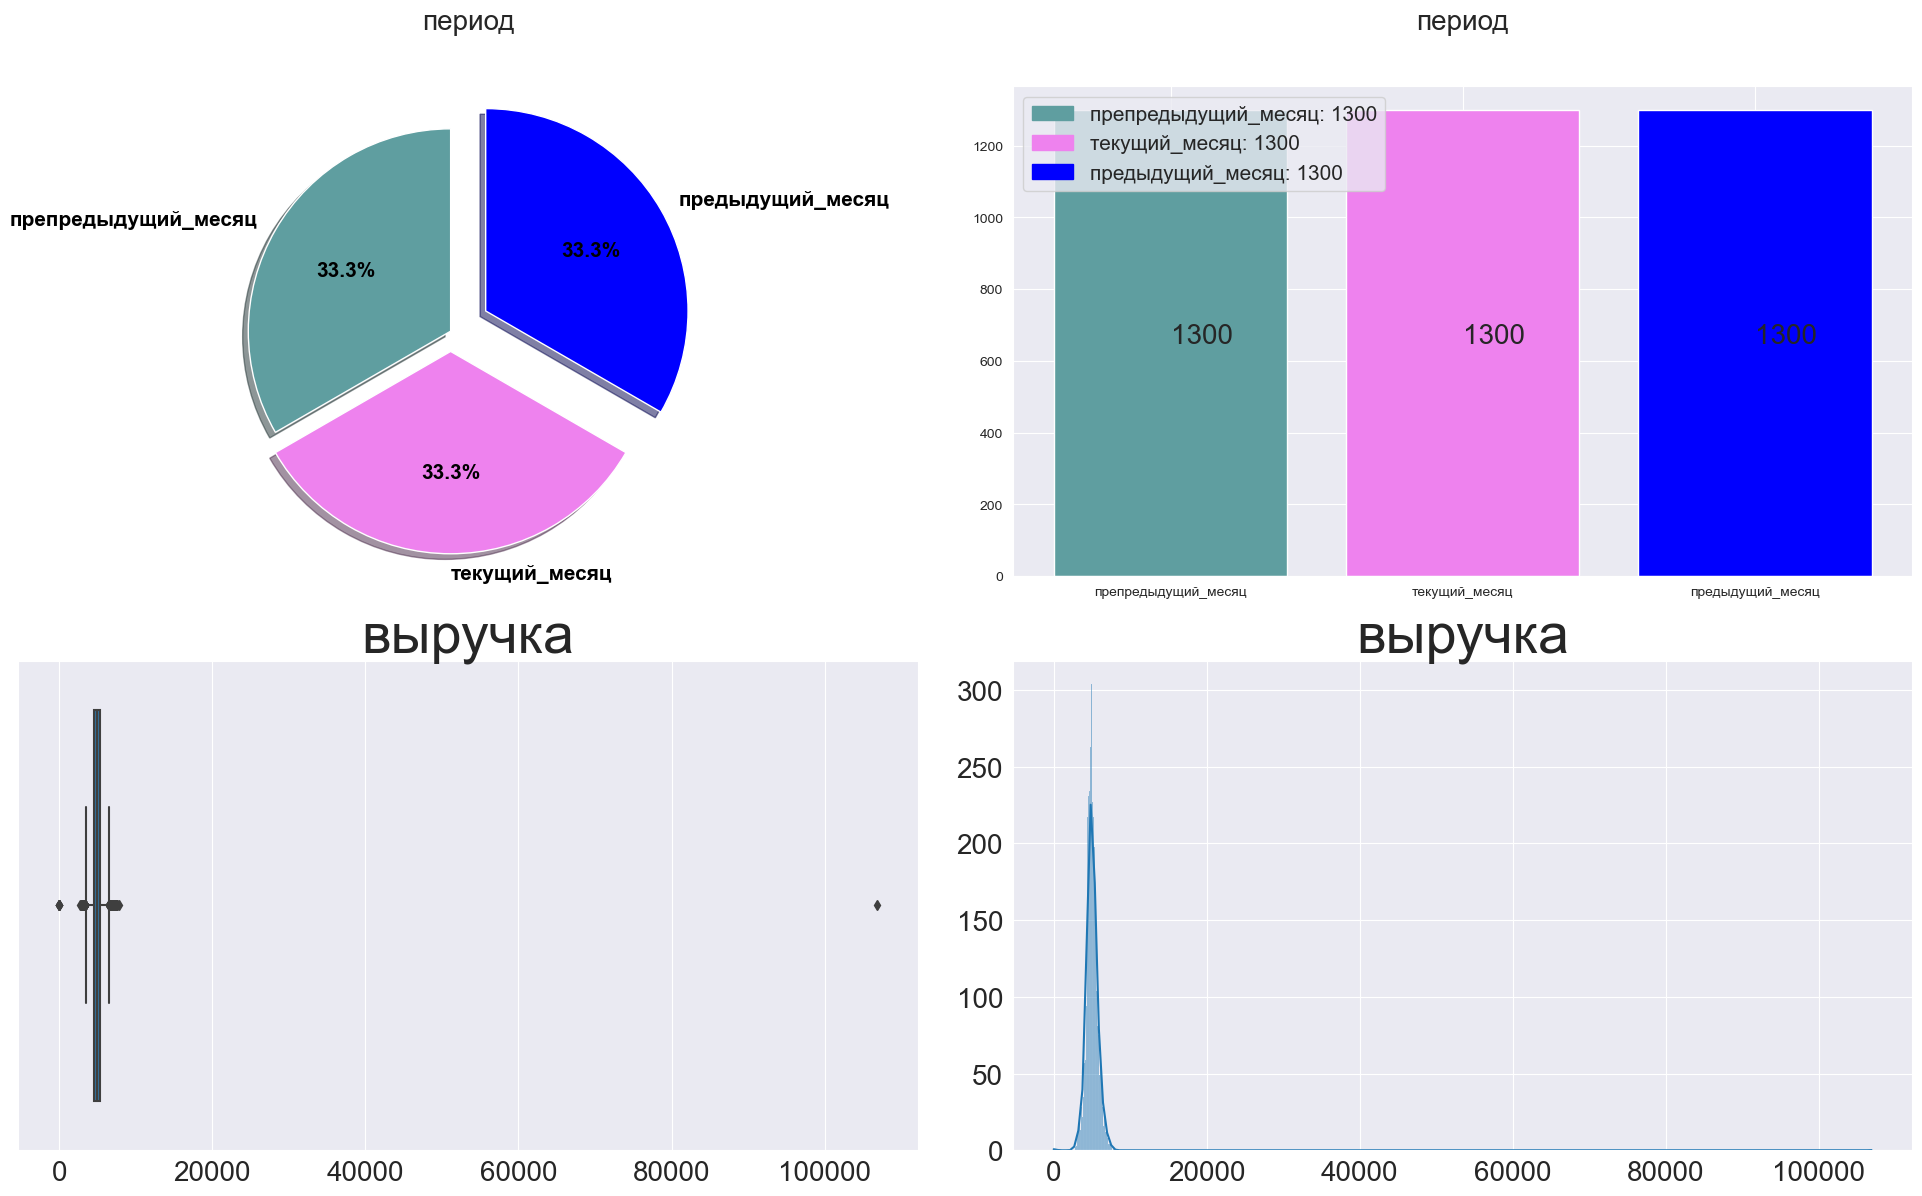

In [416]:
# Последняя таблица market_money id->период->выручка 
# сгруппируем таблицу по id, проверим все ли пользователи совершали покупки в течение 3 месяцев
print(data_market_money.groupby('id')['выручка'].sum().sort_values().head(5))
# Согласно выведенной таблице, все пользователи совершали какую либо покупку в период 3 месяца. - оставляем все данные 
figure, axes = plt.subplots(2, 2, figsize=(20, 12))
for index,i in enumerate(data_market_money.drop('id',axis=1).columns):
    if data_market_money[i].dtype==float:
        draw_box_plot(data_market_money, column=i, ax=axes[index][0])
        draw_histplot(data_market_money, column=i, ax=axes[index][1])
    else:
        draw_pie_plots_bar_plots(data_market_money,i,axes[index][0])
        draw_bar_plot(data_market_money,i,axes[index][1],text=True)
plt.tight_layout()
plt.show()
# вывод - в колонке период одиннаковое колличество записей 
# в колонке выручка есть очень грубый выброс - лучше заменить медианой или средним 

['текущий_месяц' 'предыдцщий_месяц']
2


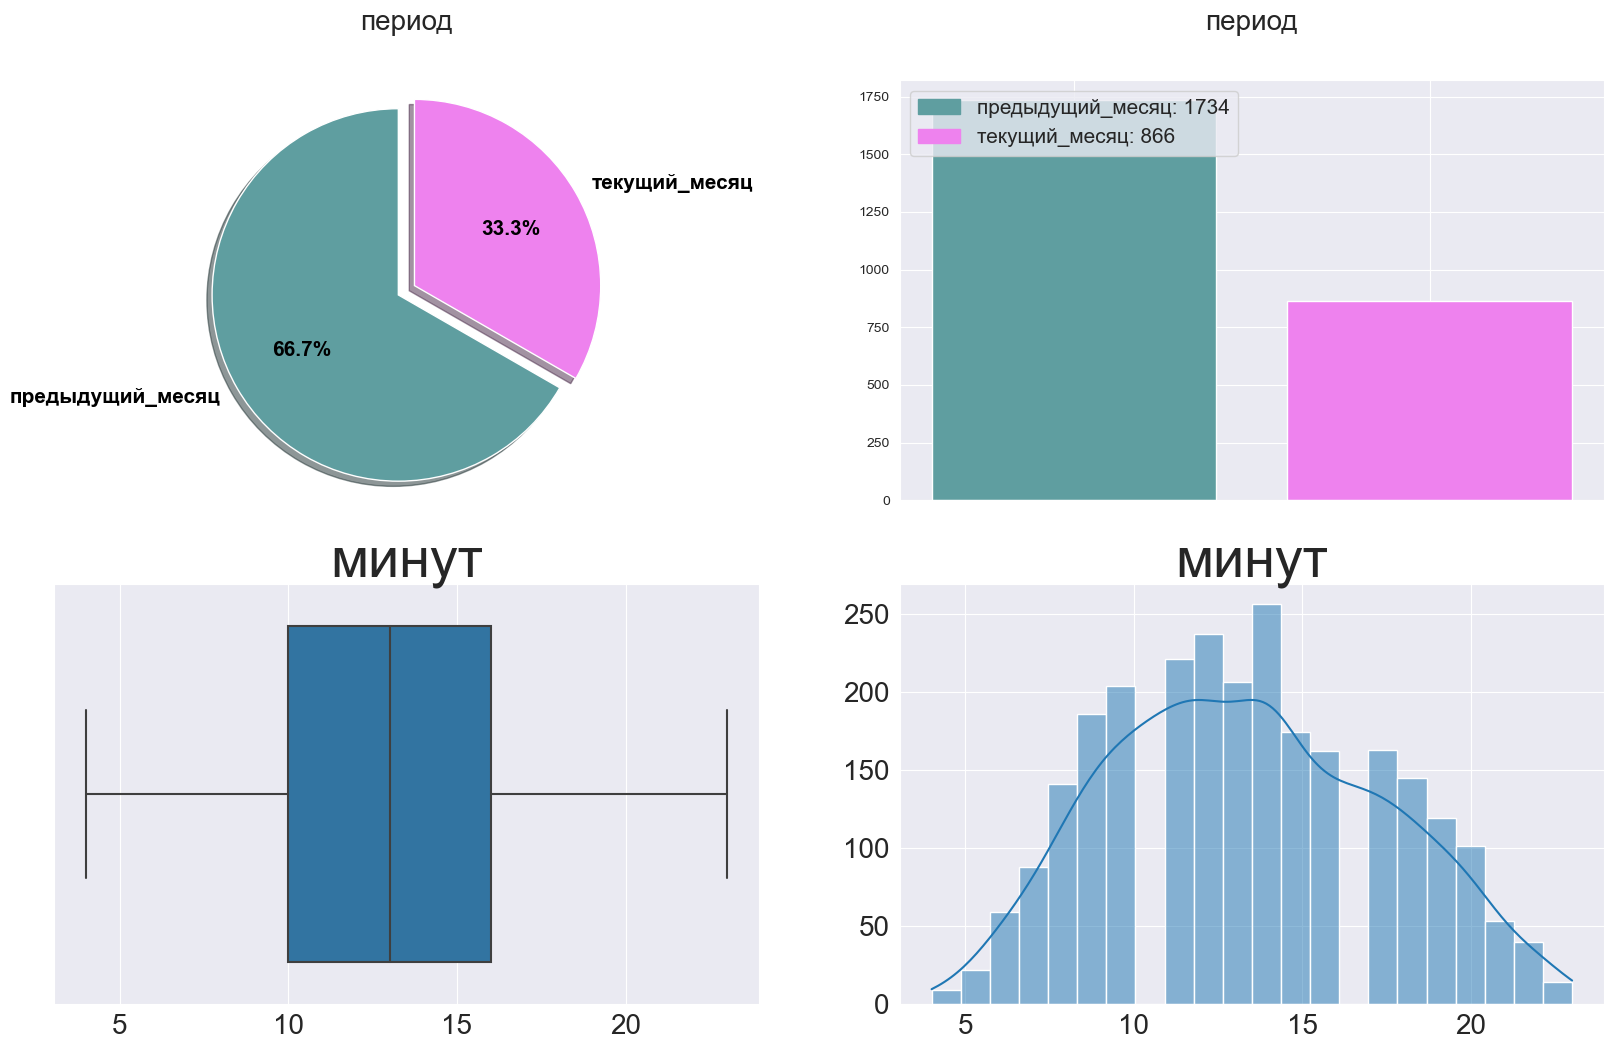

In [417]:
# Таблица market_time
print(data_market_time.период.unique())
# ошибка ввода в ['предыдцщий_месяц']
data_market_time.период=data_market_money.период.apply(lambda x:'предыдущий_месяц' if x.startswith('пре') else x)
no_id=data_market_time.drop('id',axis=1)
figure, axes = plt.subplots(no_id.shape[1], 2, figsize=(20, 12))
for index,column in enumerate(no_id.columns):
    if no_id[column].dtype!=object:
        draw_box_plot(data_market_time, column, ax=axes[index][0])
        draw_histplot(data_market_time, column, ax=axes[index][1])
    else:
        draw_pie_plots_bar_plots(data_market_time,column,axes[index][0])
        draw_bar_plot(data_market_time,column,axes[index][1],show_text)
print(data_market_time.groupby(['id']).size().max())
# данное действие вывело 2, значит в этой таблице информация о каждом пользователе с id повторяется два раза (активность может проявляться два раза в один месяц, или в рызные месяцы тоже 2 раза. Значений в предыдущем месяце намного больше, выбросов в графике минут не наблюдается)
# Пропусков значений не наблюдается, т.к график минут вывелся без ошибок.

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64


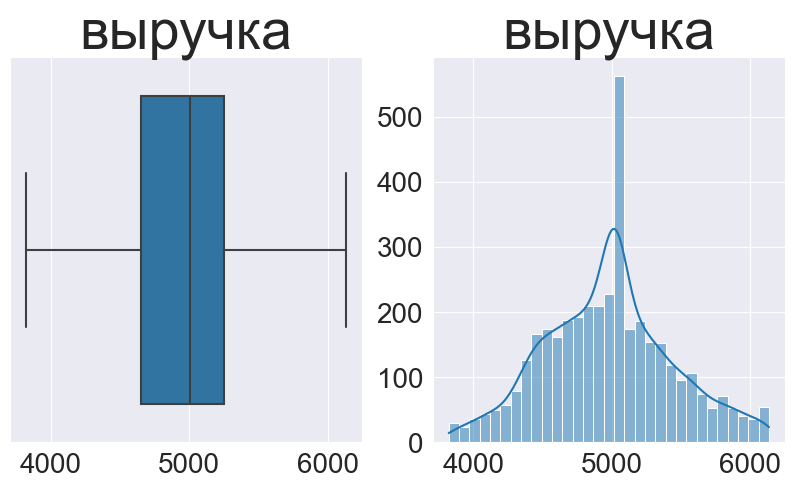

count    3900.000000
mean     4974.622148
std       464.638153
min      3821.900000
25%      4655.000000
50%      5007.750000
75%      5254.625000
max      6134.000000
Name: выручка, dtype: float64


In [418]:
# займемся выбросом -> нашли значение > 100000
print(data_market_money['выручка'].describe())
small,big=define_big_value(data_market_money,'выручка')
data_market_money['выручка']=data_market_money['выручка'].apply(lambda x:data_market_money['выручка'].mean() if (x<small or x>big) else x)
figure,ax=plt.subplots(1,2,figsize=(10,5))
draw_box_plot(data_market_money, column='выручка', ax=ax[0])
draw_histplot(data_market_money, column='выручка', ax=ax[1])
plt.show()
# print(shapiro(data_market_money['выручка'])[1]>0.5)
print(data_market_money['выручка'].describe())

In [419]:
# Время объединить таблицы.
# data_money - содержит 1300 колонок, никакая предобработка не требуется
# data_market_money - содержит 3900 колонок, по 3 записи на каждый id, сделаем отдельные колоники для каждого периода
df_money = data_market_money.pivot_table(index='id', columns='период', values='выручка').reset_index()
df_money.columns.name = None
df_money.columns=list(map(lambda x:f'выручка_{x}' if x!= 'id' else x,df_money.columns))
df_money
# получилась таблица со всеми периодами, выручка для каждого id по периоду

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,5025.696051,5025.696051,5025.696051
1,215349,5216.000000,4472.000000,4971.600000
2,215350,5457.500000,4826.000000,5058.400000
3,215351,5025.696051,4793.000000,5025.696051
4,215352,5807.500000,4594.000000,5872.500000
...,...,...,...,...
1295,216643,5025.696051,4704.000000,4741.700000
1296,216644,4729.000000,5299.000000,5353.000000
1297,216645,5160.000000,5334.000000,5139.200000
1298,216646,4923.000000,4725.000000,5224.600000


In [420]:
# В данной таблице присутствуют записи о пользователях 2 раза, не обязательно в разных месяцах.
data_market_time[data_market_time.id==215349]

,id,период,минут
2,215349,предыдущий_месяц,10
3,215349,предыдущий_месяц,12


In [421]:
df_time=data_market_time.pivot_table(index='id',columns='период',values='минут',aggfunc='sum').reset_index()
df_time.columns.name = None
df_time.columns=list(map(lambda x:f'минут_{x}' if x!='id' else x,df_time.columns))
df_time

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,14.0,13.0
1,215349,22.0,NaN
2,215350,8.0,13.0
3,215351,13.0,11.0
4,215352,11.0,8.0
...,...,...,...
1295,216643,14.0,7.0
1296,216644,23.0,NaN
1297,216645,NaN,30.0
1298,216646,25.0,NaN


In [422]:
# Заметили, что некоторые значения NaN. Это может помешать определению корреляции между данными, поэтому заполним NaN нулями
df_time=df_time.fillna(0)
df_time

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,14.0,13.0
1,215349,22.0,0.0
2,215350,8.0,13.0
3,215351,13.0,11.0
4,215352,11.0,8.0
...,...,...,...
1295,216643,14.0,7.0
1296,216644,23.0,0.0
1297,216645,0.0,30.0
1298,216646,25.0,0.0


In [423]:
# объединим таблицы
df=pd.merge(database,df_time,on='id')
df=pd.merge(df,df_money,on='id')
df
# теперь мы имеем единую таблицу. В ней предствалены данные за все периоды.

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.31,Товары для детей,6,2.0,1,5,14.0,13.0,5025.696051,5025.696051,5025.696051
1,215349,Снизилась,премиум,да,4.4,4,819,0.31,Товары для детей,4,4.0,2,5,22.0,0.0,5216.000000,4472.000000,4971.600000
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2.0,1,5,8.0,13.0,5457.500000,4826.000000,5058.400000
3,215351,Снизилась,стандарт,да,3.2,5,896,0.31,Товары для детей,5,0.0,6,4,13.0,11.0,5025.696051,4793.000000,5025.696051
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.31,Товары для детей,3,2.0,3,2,11.0,8.0,5807.500000,4594.000000,5872.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,4.4,3,318,0.24,Техника для красоты и здоровья,5,3.0,3,11,14.0,7.0,5025.696051,4704.000000,4741.700000
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2.0,3,9,23.0,0.0,4729.000000,5299.000000,5353.000000
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2.0,5,7,0.0,30.0,5160.000000,5334.000000,5139.200000
1298,216646,Прежний уровень,стандарт,да,4.4,5,645,0.12,Техника для красоты и здоровья,3,3.0,5,7,25.0,0.0,4923.000000,4725.000000,5224.600000


In [424]:
Correlation_dict=dict()
class FindCorrelation:
    def __init__(self, data, column1, column2):
        self.column1 = column1
        self.column2 = column2
        self.data = data
        if self.check_for_normality():
            self.get_correlation(method='pearson')
        else:
            self.get_correlation(method='spearman')

    def check_for_normality(self):
        alpha = 0.05
        return shapiro(self.data[self.column1])[1] > alpha and shapiro(self.data[self.column2])[1] > alpha

    def get_correlation(self, method=None):
        global Correlation_dict
        correlation=abs(self.data[[self.column1,self.column2]].corr(method=method).iloc[0,1].round(3))
        Correlation_dict[(self.column1,self.column2)]=correlation
        print('-'*50)
        print(f'Коэффицент корреляции между колонками "{self.column1}" и "{self.column2}": {correlation}')

In [425]:

# Тут выбираем колонки с колличественными шккалами, находим коэффицент корреляции между ними
numerical_columns=list(df.select_dtypes(include=[int,float]))
categorical_columns=df.select_dtypes(include=[object])
# print(categorical_columns.shape[1]+numerical_columns.shape[1]==df.shape[1]) - True, значит были задействованны все колонки
# Найдем все комбинации колонок в цифровой шкале, исключаем повторения и комбинацию из одинаковых названий 
numerical_columns.remove('id')
num_comb=list(combinations(numerical_columns,2))
for col1,col2 in num_comb:
    find_cor=FindCorrelation(df,col1,col2)

--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "маркет_актив_тек_мес": 0.06
--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "длительность": 0.043
--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "акционные_покупки": 0.246
--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "средний_просмотр_категорий_за_визит": 0.14
--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "неоплаченные_продукты_штук_квартал": 0.096
--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "ошибка_сервиса": 0.025
--------------------------------------------------
Коэффицент корреляции между колонками "маркет_актив_6_мес" и "страниц_за_визит": 0.269


In [426]:
# Мы нашли и сохранили все корреляции между числовыми колонками
# Выведем топ 6 по силе корреляций 
sorted_corr = [{key: value} for key, value in sorted(Correlation_dict.items(), key=lambda x: -x[1])]
sorted_corr[:5]
# Топ 1 и топ 2 значения - это колличество минут и выручка в предыдущем и текущем месяце. Хотя и все корреляции слабые, можно сказать что клиенты, платившие и проводившие время в предыдущем месяце на сайте скорее всего будут проводить время и платить и в текущем месяце (что говорит о их лояльности).

[{('выручка_предыдущий_месяц', 'выручка_текущий_месяц'): 0.577},
 {('минут_предыдущий_месяц', 'минут_текущий_месяц'): 0.535},
 {('акционные_покупки', 'страниц_за_визит'): 0.407},
 {('страниц_за_визит', 'выручка_препредыдущий_месяц'): 0.309},
 {('акционные_покупки', 'выручка_препредыдущий_месяц'): 0.296}]

In [427]:
# Перед следующим шагом объединим таблицы с предсказанными значениями и основной датасет
df=pd.merge(df,data_forecast,on='id')
df.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,вероятность
0,215349,Снизилась,премиум,да,4.4,4,819,0.31,Товары для детей,4,4.0,2,5,22.0,0.0,5216.000000,4472.0,4971.600000,1.00
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2.0,1,5,8.0,13.0,5457.500000,4826.0,5058.400000,0.12
2,215351,Снизилась,стандарт,да,3.2,5,896,0.31,Товары для детей,5,0.0,6,4,13.0,11.0,5025.696051,4793.0,5025.696051,0.97


In [428]:
# Напишем класс, в который будем загружать две выборки. Там будет проверятся нормальность данных, выводиться p-value, далее мы обработаем это значение и выведем результат.

In [429]:
# Напишем класс, в который будем загружать две выборки. Там будет проверятся нормальность данных, выводиться p-value, далее мы обработаем это значение и выведем результат.
have_influence = []
class AnalyticalAnalyzeNumerical:
    def __init__(self, group1, group2,col_name):
        self.group1 = group1
        self.group2 = group2
        self.pval = None
        self.col_name=col_name
        if self.check_for_normality():
            self.pval = self.student()
            self.method = 'Стьюдент'
        else:
            self.pval = self.mann()
            self.method = 'МаннаУитни'

    def check_for_normality(self):
        alpha = 0.05
        shapiro_test_group1 = shapiro(self.group1)
        shapiro_test_group2 = shapiro(self.group2)
        # если меньше, то тест не работает 
        if self.group1.shape[0] > 10 and self.group2.shape[0] > 10:
            normaltest_group1 = normaltest(self.group1)
            normaltest_group2 = normaltest(self.group2)

            if (shapiro_test_group1[1] > alpha and shapiro_test_group2[1] > alpha) or \
                    (normaltest_group1[1] > alpha and normaltest_group2[1] > alpha):
                return True
            else:
                return False
        else:
            return shapiro_test_group1[1] > alpha and shapiro_test_group2[1] > alpha

    def student(self):
        return ttest_ind(self.group1, self.group2)[1]

    def mann(self):
        return mannwhitneyu(self.group1, self.group2)[1]

    def __str__(self):
        alpha = 0.05
        global have_influence
        if self.pval < alpha:
            have_influence.append([self.col_name,self.pval])
            return f'Мы получили значение p-value {self.pval} методом {self.method}, следовательно количественная колонка {self.col_name} влияет на покупательскую активность в отобранном сегменте'
        else:
            return f'Влияния колонки {self.col_name} на покупательскую активность не обнаружено, так как p_val = {self.pval}'


class AnalyticalAnalyzeCategorical:
    def __init__(self, data, column2):
        self.data = data
        self.column1 = 'покупательская_активность'
        self.column2 = column2
        self.pval = None
        self.chi_2()

    def chi_2(self):
        cross_table = pd.crosstab(self.data[self.column1], self.data[self.column2])
        self.pval = chi2_contingency(cross_table)[1]

    def __str__(self):
        global have_influence
        if self.pval < 0.05:
            have_influence.append([self.column2,self.pval])
            return f'Колонка {self.column2} влияет на покупательскую активность с p-val = {self.pval} в отобранной группе'
        return f'Взаимосвязи между двумя категориальными колонками {self.column1} и {self.column2} не обнаружено, p_val = {self.pval}'


# класс, который будет сохранять корреляции     
Correlation_list = []


class CorrelationFinder(AnalyticalAnalyzeNumerical):
    def __init__(self, data):
        self.data = data
        self.columns_comb = list(combinations(self.data.drop('id', axis=1).columns, 2))
        self.corr = None

    def find_correlation(self):
        global Correlation_list
        for cols1, cols2 in self.columns_comb:
            self.group1 = self.data[cols1]
            self.group2 = self.data[cols2]
            if self.group1.dtype in [int, float] and self.group2.dtype in [int, float]:
                if self.check_for_normality():
                    self.corr = pearsonr(self.group1, self.group2)[0]
                else:
                    self.corr = spearmanr(self.group1, self.group2)[0]
                Correlation_list.append([cols1, cols2, abs(self.corr)])


# класс для черчения графиков
class Plotter:
    def __init__(self, data):
        self.data = data

    def draw_categories(self):
        categorical_columns = self.data.select_dtypes(include=['object'])
        fig, axes = plt.subplots(categorical_columns.shape[1], 2, figsize=(15, 15))
        show_text = True
        for index, categ in enumerate(categorical_columns):
            draw_pie_plots_bar_plots(self.data, categ, axes[index][0])
            if index == num - 1:
                show_text = False
            draw_bar_plot(self.data, categ, axes[index][1], show_text)
        plt.tight_layout()
        plt.show()

    def draw_numerical(self):
        numerical_columns = self.data.select_dtypes(include=[int, float])
        fig, axes = plt.subplots(numerical_columns.shape[1], 2, figsize=(30, 30))
        for index, column_name in enumerate(numerical_columns):
            draw_box_plot(self.data, column_name, axes[index][0])
            draw_histplot(self.data, column_name, axes[index][1])
        plt.tight_layout()
        plt.show()


['минут_предыдущий_месяц', 'минут_текущий_месяц', 0.5657701994314848]
['выручка_предыдущий_месяц', 'выручка_текущий_месяц', 0.5058667933224635]
['средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 0.31435199831254446]
['длительность', 'вероятность', 0.2863200013908262]
['длительность', 'страниц_за_визит', 0.2825853533519976]


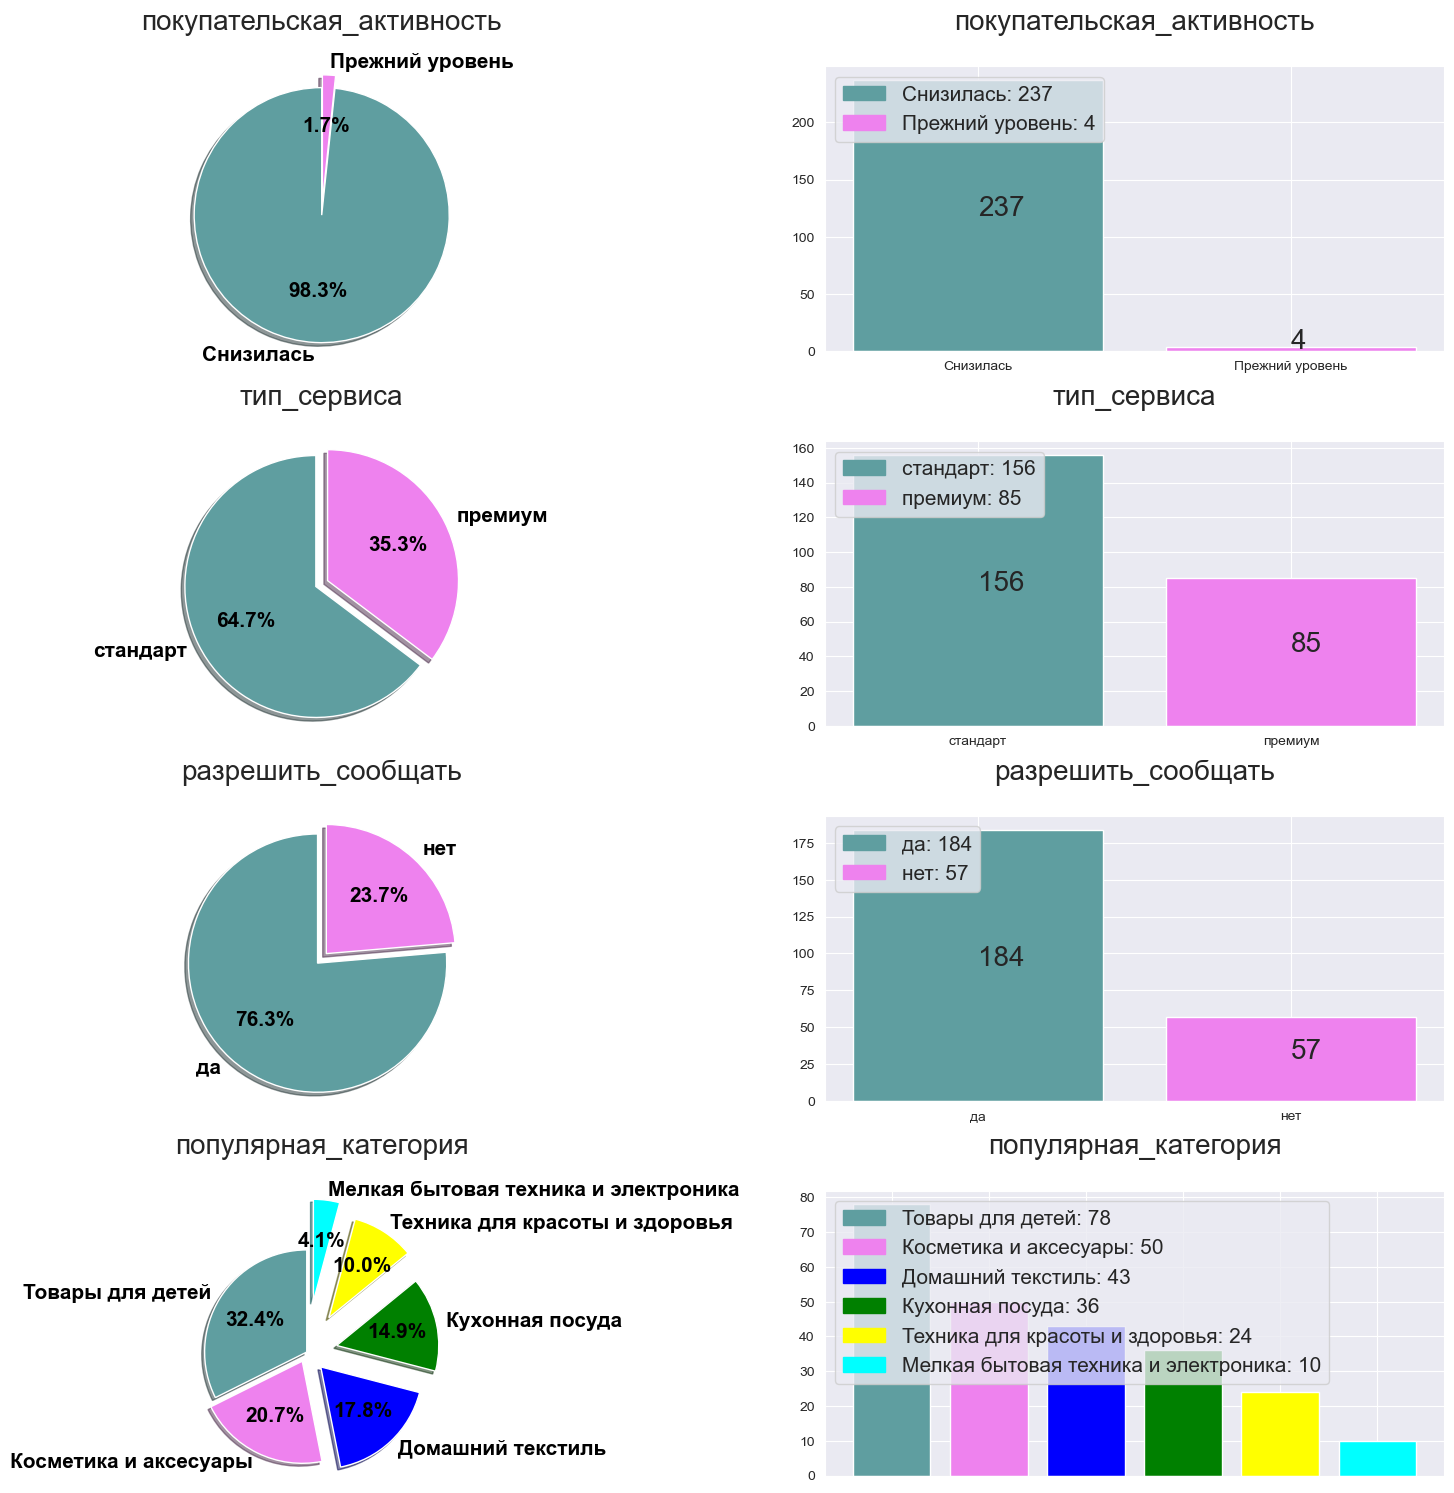

In [430]:
# Группа 1 - Группа клиентов с высокой долей покупок по акции и высокой вероятностью снижения покупательской активности.
# Возьмем высокое значение - среднее + 1 стандартное  отклонения - 273 колонок всего 
# Высокая вероятность - больше 60 процентов

group1=df[(df['акционные_покупки']>=df['акционные_покупки'].mean()+1*df['акционные_покупки'].std()) & (df['вероятность']>0.6)]

theory_num=1
corr_finder=CorrelationFinder(group1)
corr_finder.find_correlation()
corr_list=sorted(Correlation_list,key=lambda x:-x[2])
print(*corr_list[:5],sep='\n')
# Видно, что новых корреляций не появилось. Можно заметить что в этом сегменте колличество минут в пердыдущем месяце и в текущем могут быть зависимы (старые клиенты).
group1=group1.drop(['id','акционные_покупки','вероятность'],axis=1)
pl=Plotter(group1)
pl.draw_categories()
# Вывели графики. Несколько важных выводов
# 1) Можем завметить что в данном сегменте катострафически мало значений, где активность на прежнем уровне. Согласно графикам, всего 1.4 процента клиентов проявляют активность на прежнем уровне. Мы выбрали клиентов, где вероятность снижения активности больше 0.6, графики подтверждают эту тенденцию.
# 2) Большинство клиентов выбирают тип сервиса стандарт, всего 35 процентов премиума
# 3) Более 70 процентов клиентов разрешили сообщать. Клиенты готовы принимать новые предложения о товаре, следовательно чтобы снизить тенденцию снижения активности следует как-либо поощрять их через рассылку (например присылать сертификаты или подарочные коды) 
# 4) Самая популярная категория это товары для детей и косметика. Этот сегмент покупает товары по акции, снижение активности может быть обусловлена отсутсвием скидок в подходящий момент. Решение - создать сезонные скидки для этих товаров и проводить акции. 

       маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count          241.000000            241.000000    241.000000   
mean             3.935270              3.991701    629.398340   
std              0.596902              0.701140    240.789775   
min              2.600000              3.000000    135.000000   
25%              3.600000              4.000000    458.000000   
50%              3.900000              4.000000    657.000000   
75%              4.100000              4.000000    819.000000   
max              5.600000              5.000000   1073.000000   

       средний_просмотр_категорий_за_визит  \
count                           241.000000   
mean                              2.572614   
std                               1.205852   
min                               1.000000   
25%                               2.000000   
50%                               2.000000   
75%                               3.000000   
max                               6.000000   


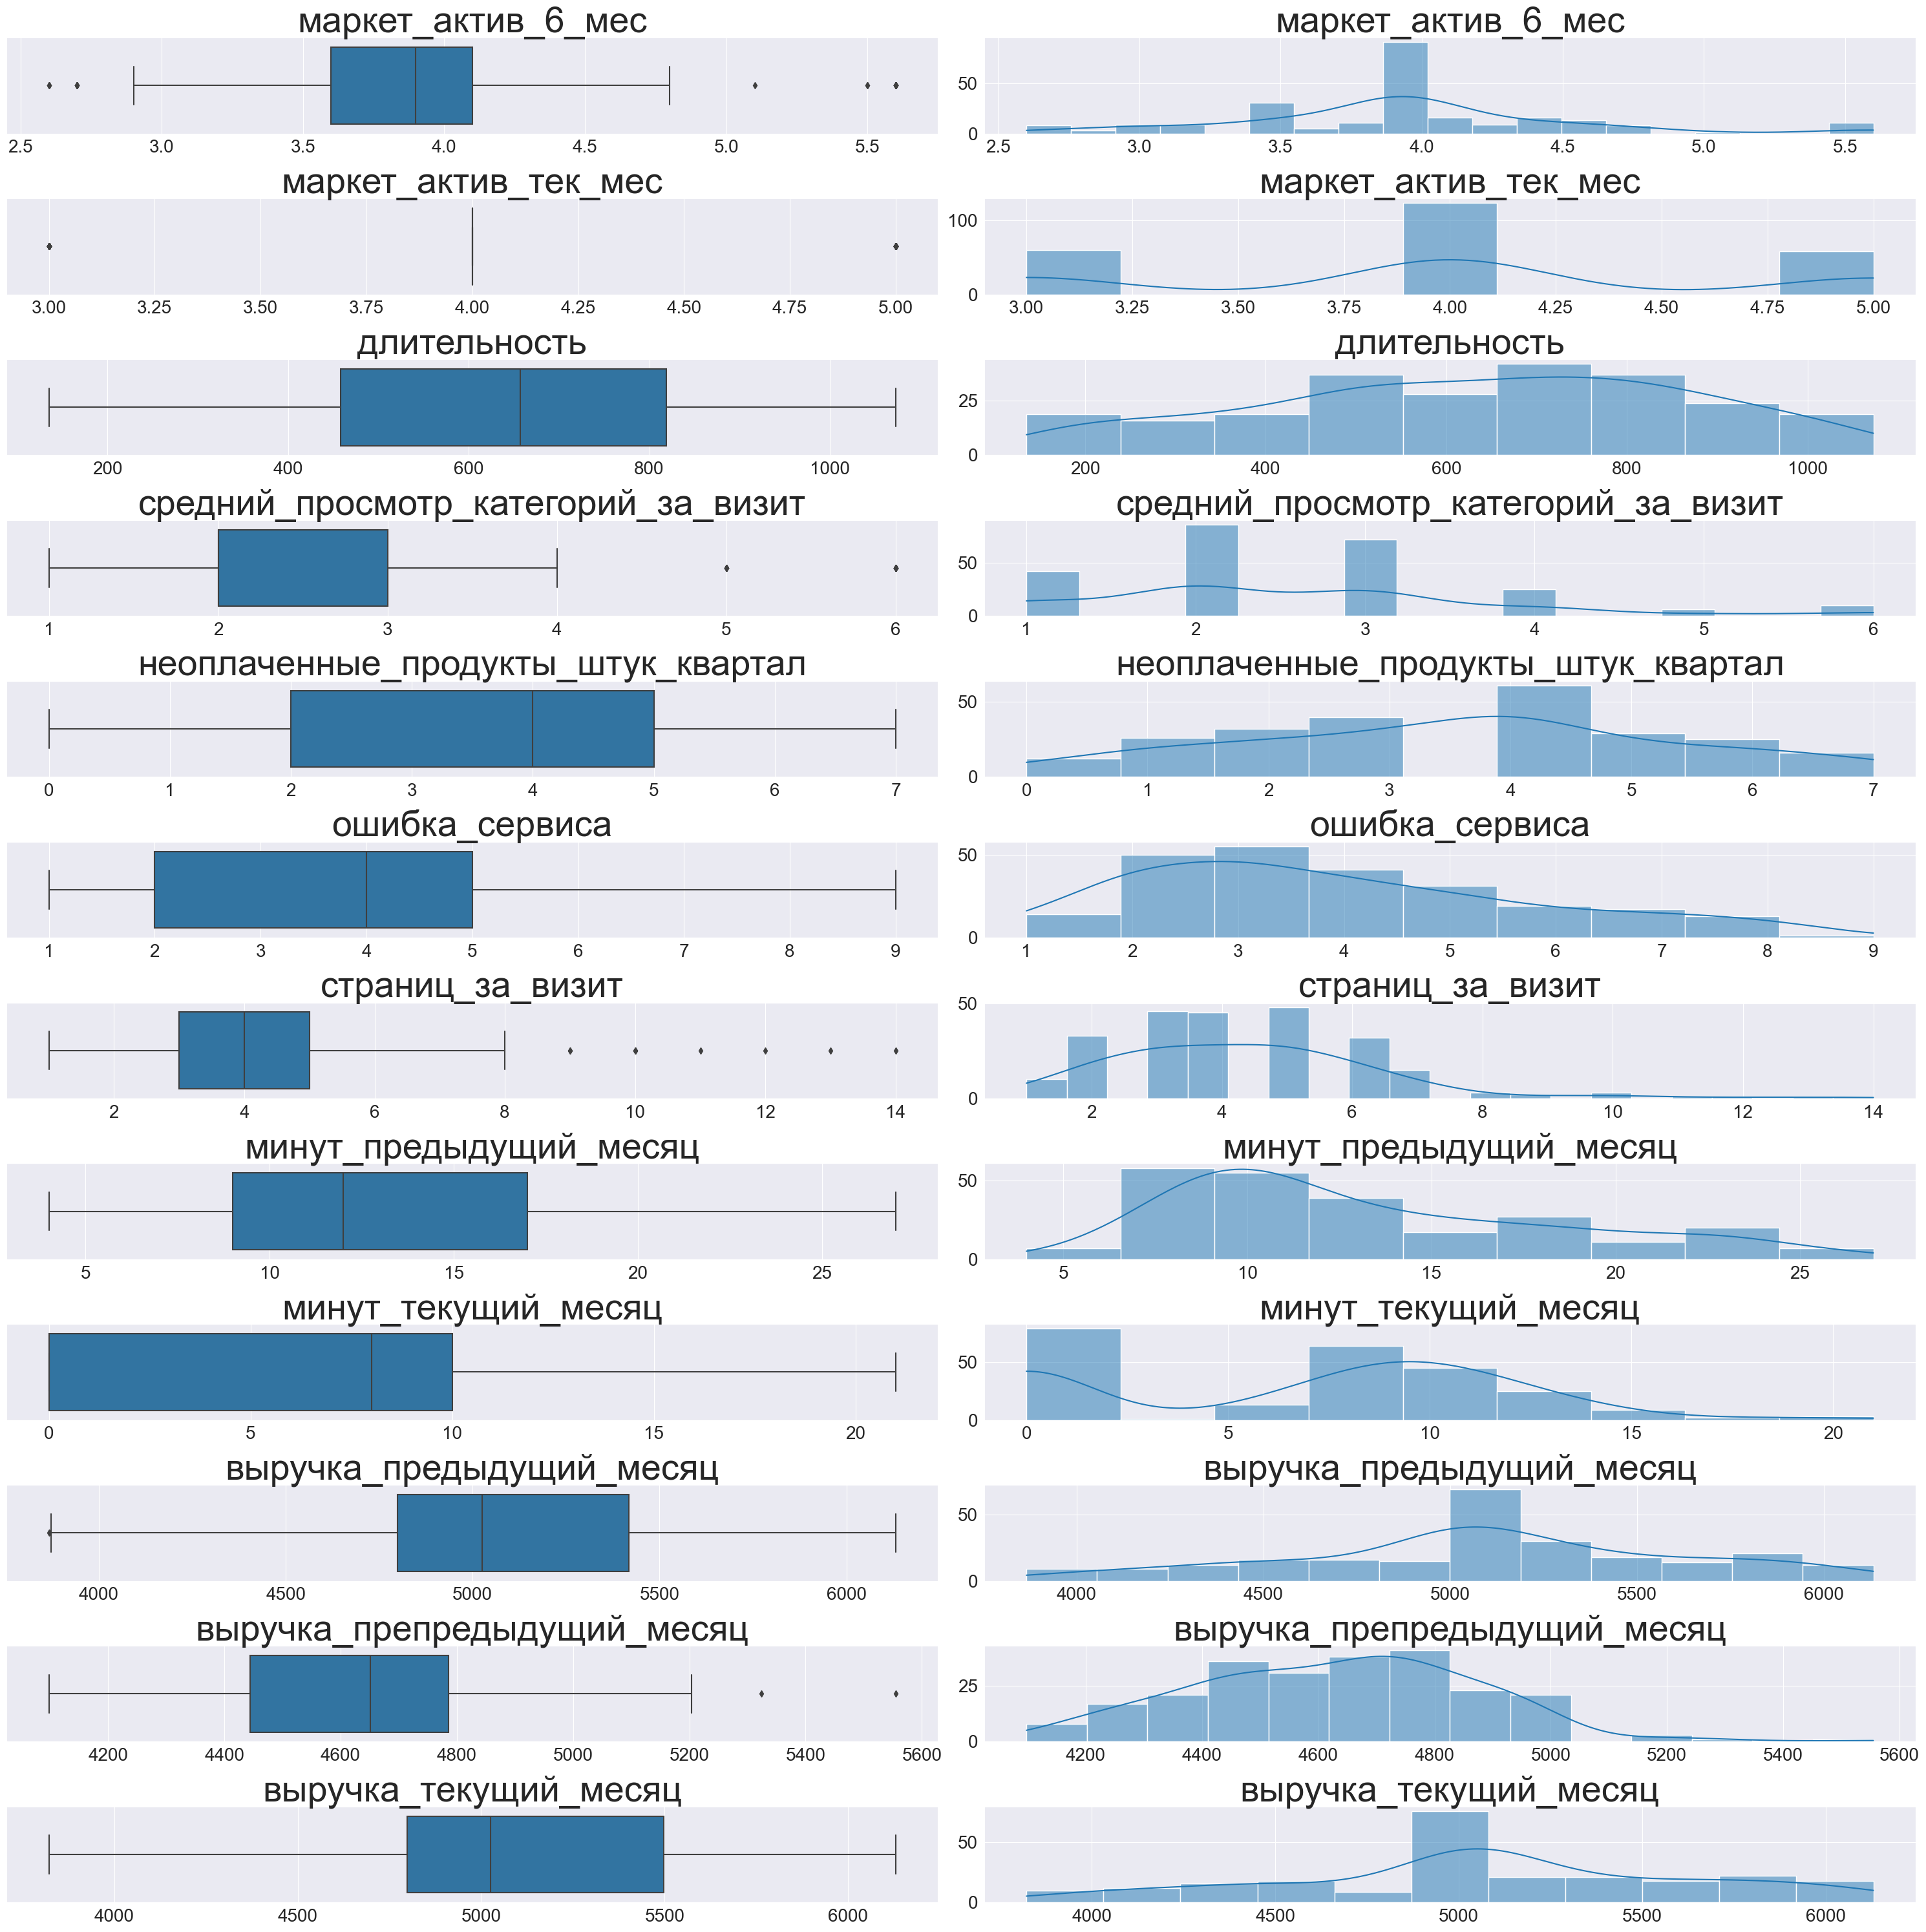

In [431]:
# проведем аналитический и графический анализ коллич. факторов
print(group1.describe())
pl.draw_numerical()
# Итоги

# 1) в колонке маркет_актив_6_мес есть выбросы в большую сторону и в меньшую. Медиана сдвинута больше влево чем на графике основного датасета, клиенты в этом сегменте менее активны за 6 месяцев.
# 2) В маркет_актив_тек_месприсутствуют только 3 значения, что достаточно странно
# 3) Цифры в длительности регистрации похожи на цифры в основном датесете, преимущественно старые клиенты 
# 4) В основном за визит просмотрено 2-3 категорий, что достаточно мало по сравнению с генеральной совокупностью (там медиана 3 категории, значения достигают 4 штуки). 
# 5) График минут в текущем месяце выглядит интересно. Согласно картинкам, Преобладают значения 0 и до 10 минут. Эта колонка напрямую показывает снижение активности.
# 6) Выручка за предыдущий месяц больше чем за предпредыдущий, причем значительно. Выручка очень мала за текущий месяц (активность определенно понизилась).

In [432]:
# Далее разделим данные по группам (согласно категориальным признакам [тип_сервиса, разрешить_сообщать, популярная категория]
# может быть покупательская активность будет зависеть от опреленных категориальных переменных. 
# затем проверим 

# an=AnalyticalAnalyze(group1,group2,theory_num)
# print(an)
# Группа клиентов с высокой долей покупок по акции и высокой вероятностью снижения покупательской активности.
# Вывод - p-value вышел больше устанавливаемого числа, значит большия значения акционных покупок и большая вероятность снижения не влияют на покупательскую активность 
for column_name in group1.columns:
    if column_name!='покупательская_активность':
        # Посмотрим, есть ли корреляции между колличественными факторами в данном сегменте и целевой покупательская активность
        if group1[column_name].dtype in [int,float]:
            group1_1=group1[group1['покупательская_активность']=='Снизилась'][column_name]
            group1_2=group1[group1['покупательская_активность']!='Снизилась'][column_name]
            num=AnalyticalAnalyzeNumerical(group1_1,group1_2,col_name=column_name)
            print(num)
            print('-'*50)
        # Посмотрим, есть ли корреляции между категориальнами факторами в данном сегменте и целевой покупательская активность
        else:
            cat=AnalyticalAnalyzeCategorical(group1,column_name)
            print(cat)
            print('-'*50)

Взаимосвязи между двумя категориальными колонками покупательская_активность и тип_сервиса не обнаружено
--------------------------------------------------
Взаимосвязи между двумя категориальными колонками покупательская_активность и разрешить_сообщать не обнаружено
--------------------------------------------------
Влияния колонки маркет_актив_6_мес на покупательскую активность не обнаружено, так как p_val = 0.9154118901165308
--------------------------------------------------
Влияния колонки маркет_актив_тек_мес на покупательскую активность не обнаружено, так как p_val = 0.4576130370225556
--------------------------------------------------
Влияния колонки длительность на покупательскую активность не обнаружено, так как p_val = 0.12972332137108286
--------------------------------------------------
Взаимосвязи между двумя категориальными колонками покупательская_активность и популярная_категория не обнаружено
--------------------------------------------------
Влияния колонки средний_про

In [433]:
# Мы проверили влияние категориальных и колличественных колонок на целевую
print(have_influence)
# согласно списку, с ошибкой 0.9 процентов мы можем утверждать, что колличество страниц, посещенных за визит напрямую влияет на покупательскую активность в рассмотренном сегменте клиентов. 

[['страниц_за_визит', 0.0009098881741970812]]
